# Ads Marketing - Statistics for Business 

####  Author : Nicodemus Naisau (demsroadmap@gmail.com)

___

#### Import Liblary

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.gridspec import GridSpec
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import colorlover as cl 
#stats
import scipy.stats as stats

# modelling
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

# path_file
from pathlib import Path
from datetime import date

# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

import warnings
warnings.filterwarnings("ignore") 

#### Define function

In [2]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame>  combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

#### **Loading data into Dataframe**

In [3]:
marketing = pd.read_csv('marketing.csv')
marketing.head()

,Ad Group,Month,Impressions,Clicks,CTR,Conversions,Conv Rate,Cost,CPC,Revenue,Sale Amount,P&L
0,Shop - 1:1 - Desk - [shop coupon code],July,16038,6504,0.41,1166,0.10,6669,1.03,6402,136770.05,-267.086
1,Shop - 1:1 - Desk - [shop coupon],July,36462,14367,0.39,2188,0.09,13746,0.96,13262,283215.21,-483.951
2,Shop - 1:1 - Desk - [shop discount code],July,3635,1458,0.40,248,0.09,1606,1.10,1723,39165.46,117.136
3,Shop - 1:1 - Desk - [shop promo code],July,26185,10418,0.40,2294,0.12,13278,1.27,13042,284823.48,-235.921
4,Shop - 1:1 - Desk - [shop promo],July,808,282,0.35,61,0.15,391,1.39,337,7717.77,-53.604


#### Rename name columns

In [4]:
marketing = marketing.rename(columns={
    'Ad Group': 'Ad_Group',
    'Conv Rate': 'Conversion_Rate',
    'Sale Amount': 'Sale_Amount',
})

- First, we should take a look at our dataset. 
 - We can check the number of observation that experience old web page and the new one 
 - Check Missing Value, and handle it if any.
 - Check duplicates, and handle it if any.

#### Explore the data

In [5]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ad_Group         190 non-null    object 
 1   Month            190 non-null    object 
 2   Impressions      190 non-null    int64  
 3   Clicks           190 non-null    int64  
 4   CTR              190 non-null    float64
 5   Conversions      190 non-null    int64  
 6   Conversion_Rate  190 non-null    float64
 7   Cost             190 non-null    int64  
 8   CPC              190 non-null    float64
 9   Revenue          190 non-null    int64  
 10  Sale_Amount      190 non-null    float64
 11  P&L              190 non-null    float64
dtypes: float64(5), int64(5), object(2)
memory usage: 17.9+ KB


In [6]:
marketing.isnull().sum()

Ad_Group           0
Month              0
Impressions        0
Clicks             0
CTR                0
Conversions        0
Conversion_Rate    0
Cost               0
CPC                0
Revenue            0
Sale_Amount        0
P&L                0
dtype: int64

In [7]:
marketing['Ad_Group'].value_counts().head()

Shop - 1:1 - Desk - [shop coupon code]    5
Shop - Phrase - Desk - Promo Code         5
Shop - Exact - Mob - Offer                5
Shop - Exact - Mob - Promo Code           5
Shop - Exact - Mob - Sale                 5
Name: Ad_Group, dtype: int64

#### **Manipulation Data**

In [8]:
# split the "ad_group" column by " - " and create new columns
marketing[["name_store", "keyword_match", "device_type", "landing_page"]] = marketing["Ad_Group"].str.split(" - ", expand=True)

In [9]:
marketing

,Ad_Group,Month,Impressions,Clicks,CTR,Conversions,Conversion_Rate,Cost,CPC,Revenue,Sale_Amount,P&L,name_store,keyword_match,device_type,landing_page
0,Shop - 1:1 - Desk - [shop coupon code],July,16038,6504,0.41,1166,0.10,6669,1.03,6402,136770.05,-267.086,Shop,1:1,Desk,[shop coupon code]
1,Shop - 1:1 - Desk - [shop coupon],July,36462,14367,0.39,2188,0.09,13746,0.96,13262,283215.21,-483.951,Shop,1:1,Desk,[shop coupon]
2,Shop - 1:1 - Desk - [shop discount code],July,3635,1458,0.40,248,0.09,1606,1.10,1723,39165.46,117.136,Shop,1:1,Desk,[shop discount code]
3,Shop - 1:1 - Desk - [shop promo code],July,26185,10418,0.40,2294,0.12,13278,1.27,13042,284823.48,-235.921,Shop,1:1,Desk,[shop promo code]
4,Shop - 1:1 - Desk - [shop promo],July,808,282,0.35,61,0.15,391,1.39,337,7717.77,-53.604,Shop,1:1,Desk,[shop promo]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Shop - Exact - Desk - Black Friday/Cyber Monday,November,257,24,0.09,7,0.28,3,0.14,45,898.80,41.946,Shop,Exact,Desk,Black Friday/Cyber Monday
186,Shop - 1:1 - Desk - [shop discount code],November,7254,2725,0.38,512,0.11,3182,1.17,3227,66672.29,45.468,Shop,1:1,Desk,[shop discount code]
187,Shop - Exact - Desk - Coupon Code,November,18526,5553,0.30,919,0.10,5982,1.08,6047,129556.90,64.552,Shop,Exact,Desk,Coupon Code
188,Shop - Exact - Mob - Black Friday/Cyber Monday,November,3662,266,0.07,24,0.09,44,0.17,160,3268.63,115.963,Shop,Exact,Mob,Black Friday/Cyber Monday


In [10]:
unique_values_landing_page = marketing['landing_page'].unique()
unique_values_landing_page

array(['[shop coupon code]', '[shop coupon]', '[shop discount code]',
       '[shop promo code]', '[shop promo]', 'Competitor', 'Coupon Code',
       'Discount Code', 'Free Shipping', 'Offer', 'Promo Code', 'Sale',
       'Black Friday/Cyber Monday'], dtype=object)

In [11]:
marketing.describe()

,Impressions,Clicks,CTR,Conversions,Conversion_Rate,Cost,CPC,Revenue,Sale_Amount,P&L
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,14077.363158,4865.805263,0.272105,505.242105,0.079737,3344.063158,0.791263,2957.684211,63416.180579,-386.361916
std,29771.686227,11348.529219,0.107894,1052.202922,0.052859,6524.606753,0.403312,5962.413097,125414.656922,903.073776
min,35.000000,2.000000,0.050000,0.000000,0.000000,1.000000,0.140000,0.000000,0.000000,-5672.271000
25%,1065.000000,264.500000,0.192500,24.000000,0.050000,188.500000,0.480000,144.500000,2985.135000,-294.977500
50%,4969.000000,930.000000,0.285000,70.500000,0.070000,563.500000,0.635000,459.500000,10274.105000,-75.978000
75%,13380.000000,4190.500000,0.360000,428.250000,0.100000,2967.000000,1.107500,2672.250000,59345.195000,-6.027500
max,276568.000000,99526.000000,0.470000,7563.000000,0.500000,43542.000000,2.020000,42440.000000,886095.310000,1507.685000


#### **Distribution Data**

In [12]:
num_cols = ['Cost', 'Revenue', 'Sale_Amount']

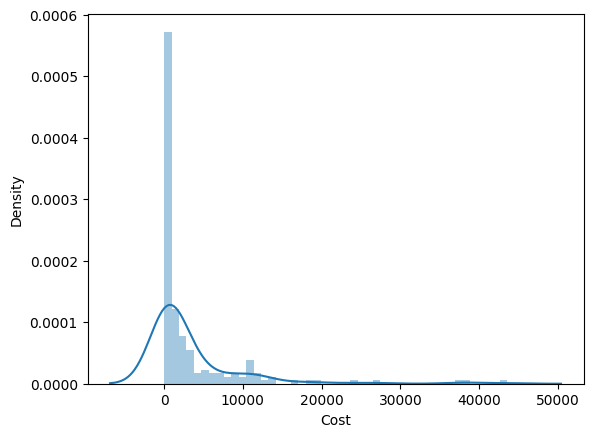

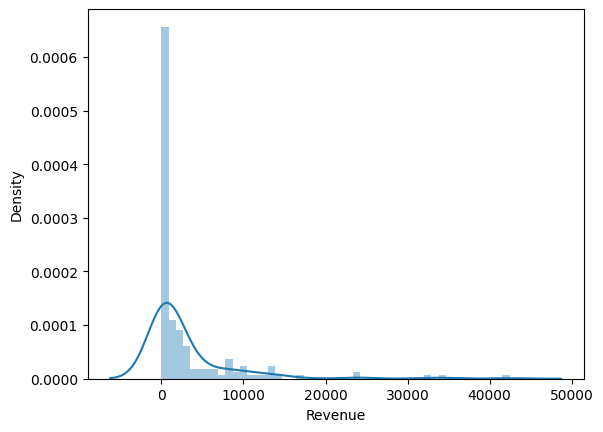

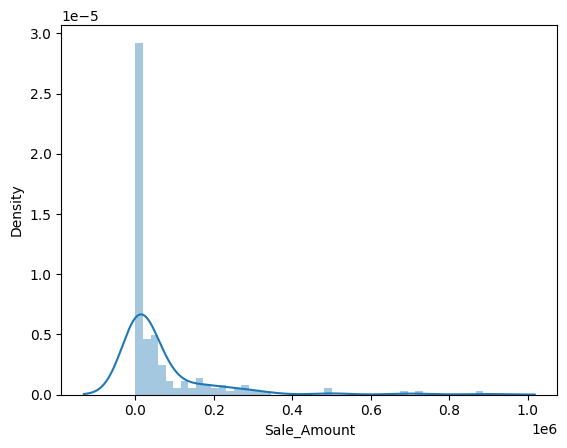

In [13]:
for i in num_cols:
    sns.distplot(marketing[i])
    plt.show()

In [14]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ad_Group         190 non-null    object 
 1   Month            190 non-null    object 
 2   Impressions      190 non-null    int64  
 3   Clicks           190 non-null    int64  
 4   CTR              190 non-null    float64
 5   Conversions      190 non-null    int64  
 6   Conversion_Rate  190 non-null    float64
 7   Cost             190 non-null    int64  
 8   CPC              190 non-null    float64
 9   Revenue          190 non-null    int64  
 10  Sale_Amount      190 non-null    float64
 11  P&L              190 non-null    float64
 12  name_store       190 non-null    object 
 13  keyword_match    190 non-null    object 
 14  device_type      190 non-null    object 
 15  landing_page     190 non-null    object 
dtypes: float64(5), int64(5), object(6)
memory usage: 23.9+ KB


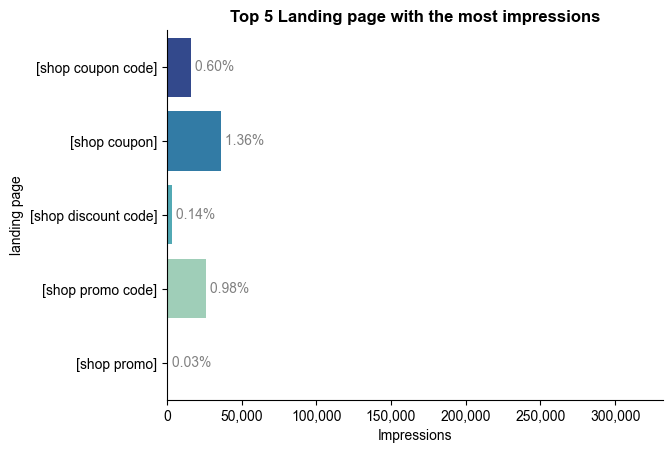

In [15]:
### Visualising top 10 lowest bought product categories:
ax = sns.barplot(x='Impressions',y='landing_page',data=marketing[:5],palette="YlGnBu_r")
sns.set(style = 'whitegrid')
plt.ylabel("landing page")
plt.xlabel("Impressions")
plt.xticks(rotation='horizontal')
total = marketing['Impressions'].sum()
#formmater comma
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#percantage
for c in ax.containers:
        labels = [f" {(value.get_width() / total):.2%}" for value in c]
        ax.bar_label(c, labels=labels, label_type="edge",fontsize='smaller', fontname='Sans',color='grey')    


for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
ax.set_title(
        "Top 5 Landing page with the most impressions",
        fontdict={"fontweight": "bold"}
    )
plt.savefig(
        Path(".") / "plots" / f"high_Impressions_landing_page.png",
        bbox_inches="tight",
        dpi=200,
    )
ax.set(
        xlim=(None, marketing["Impressions"].max() * 1.2)
    )  
plt.show()

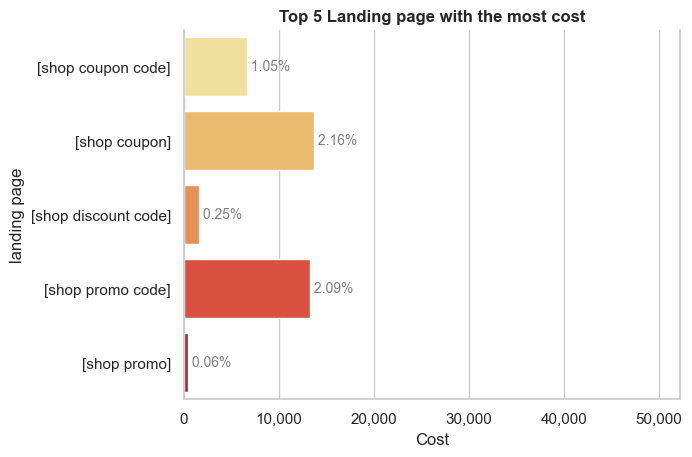

In [16]:
### Visualising top 10 lowest bought product categories:
ax = sns.barplot(x='Cost',y='landing_page',data=marketing[:5],palette="YlOrRd")
sns.set(style = 'whitegrid')
plt.ylabel("landing page")
plt.xlabel("Cost")
plt.xticks(rotation='horizontal')
total = marketing['Cost'].sum()
#formmater comma
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#percantage
for c in ax.containers:
        labels = [f" {(value.get_width() / total):.2%}" for value in c]
        ax.bar_label(c, labels=labels, label_type="edge",fontsize='smaller', fontname='Sans',color='grey')    


for spine in ['top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title(
        "Top 5 Landing page with the most cost",
        fontdict={"fontweight": "bold"}
    )
plt.savefig(
        Path(".") / "plots" / f"high_cost_landing_page.png",
        bbox_inches="tight",
        dpi=200,
    )
ax.set(
        xlim=(None, marketing["Cost"].max() * 1.2)
    )  
plt.show()

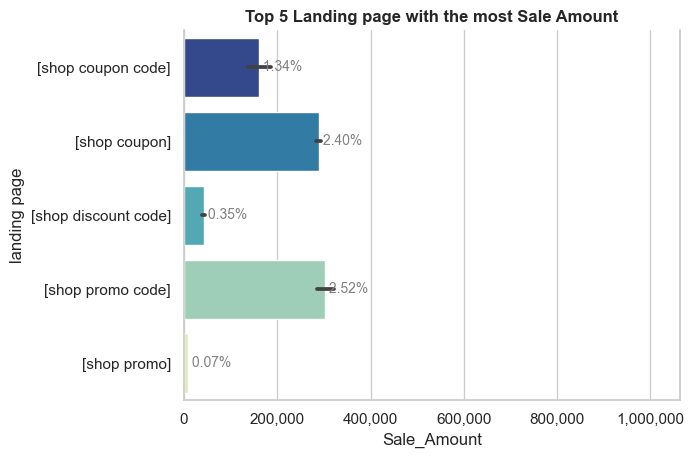

In [17]:
### Visualising top 10 lowest bought product categories:
ax = sns.barplot(x='Sale_Amount',y='landing_page',data=marketing[:10],palette="YlGnBu_r")
sns.set(style = 'whitegrid')
plt.ylabel("landing page")
plt.xlabel("Sale_Amount")
plt.xticks(rotation='horizontal')
total = marketing['Sale_Amount'].sum()
#formmater comma
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#percantage
for c in ax.containers:
        labels = [f" {(value.get_width() / total):.2%}" for value in c]
        ax.bar_label(c, labels=labels, label_type="edge",fontsize='smaller', fontname='Sans',color='grey')    


for spine in ['top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title(
        "Top 5 Landing page with the most Sale Amount",
        fontdict={"fontweight": "bold"}
    )
plt.savefig(
        Path(".") / "plots" / f"high_saleAmount_landing_page.png",
        bbox_inches="tight",
        dpi=200,
    )
ax.set(
        xlim=(None, marketing["Sale_Amount"].max() * 1.2)
    )  
plt.show()

## **Statistics Test**
___

The company has been tracking the Click for the Landing Page of Website for 5 months. The company now wants to conduct a statistical test to determine if there is a significant difference in the Click between November and October.

- What we want to prove is whether the proportion of clicks from the landing page in November is **less than or equal** to the proportion of clicks from the landing page in October. 
- Let $p_1$ is represent the proportion of Clicks from landing in **November** and $p_2$ is represent the proportion of Clicks from landing in **October**

- Then we state Null hypothesis ($H_0$) as status quo, where we shouldn't do anything and have no data 
 - $H_0$:The proportion of clicks from landing page in November is **greater than** to the proportion of clicks from landing page in October.
   $$H_0:P_1 \geq P_2$$
- Alternative hypothesis ($H_1$) is the opposite claim from null hypothesis
 - $H_1$: The proportion of clicks from landing page in November is **less than or equal** the proportion of clicks from landing page in October. $$H_1:P_1 \le P_2$$
- Set siginificance level (alpha)
 - Significance level = 0.05`

#### **Define Null & Alternate Hypothesis**

*What the default condition in the company?*
- [x] There is significant difference in the Click between for proportion of clicks from landing page in `November` and `October`.
- [ ] There is no a significant difference in the Click between the two landing pages for `shop promo code` and `shop coupon code`

<font color="blue">Explaination</font><br>
This means that the company assumes that both landing pages in October have the different Clicks and that any observed differences are due to same.

In [18]:
november_clicks = marketing[marketing['Month'] == 'August']['Clicks']
october_clicks = marketing[marketing['Month'] == 'October']['Clicks']

In [19]:
november_clicks_len = len(november_clicks)
october_clicks_len = len(october_clicks)

november_clicks_sum = november_clicks.sum()
october_clicks_sum = october_clicks.sum()

- Afterward, we can calculate statistics test and p-value using spicy library.

- There are several steps to calculate two-sample z-test for proportions using statsmodels

1. import library 

    - from statsmodels import [proportions_ztest](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html)
    
    
2. Using function`proportions_ztest(count = ... , nobs = ... , alternative = ... )` by replacing parameters  :
    - `count` : number of successes
    - `nobs` : number of observations
    - `alternative` : It depends on the alternative hypothesis for the test
        - if $H_1$ is not equal to certain value, we use `two-sided`
        - if $H_1$ is larger than certain value, we use `larger`
        - if $H_1$ is smaller than certain value, we use `smaller` 
        
3. The function will return two output, namely test statistic and p-value.m

In [20]:
from statsmodels.stats.proportion import proportions_ztest

# Perform two proportion z-test
z_stat, p_value = proportions_ztest(count = [november_clicks_len, october_clicks_len], 
                                                nobs = [november_clicks_sum, october_clicks_sum], 
                                                alternative = 'smaller')

print("The computed Z test statistic is: ",np.round(z_stat, 4))
print("The p-value is: ", np.round(p_value,4))

The computed Z test statistic is:  0.0301
The p-value is:  0.512


In [21]:
# critical value in our case is z-value where the left-tailed area under a standard normal distribution is 0.05 (alpha)
import scipy.stats as stats
z_crit = stats.norm.ppf(1-0.05)
print(z_crit)

1.6448536269514722


In [22]:
# Decision rule
if p_value<0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the Null hypothesis")

Failed to reject the Null hypothesis


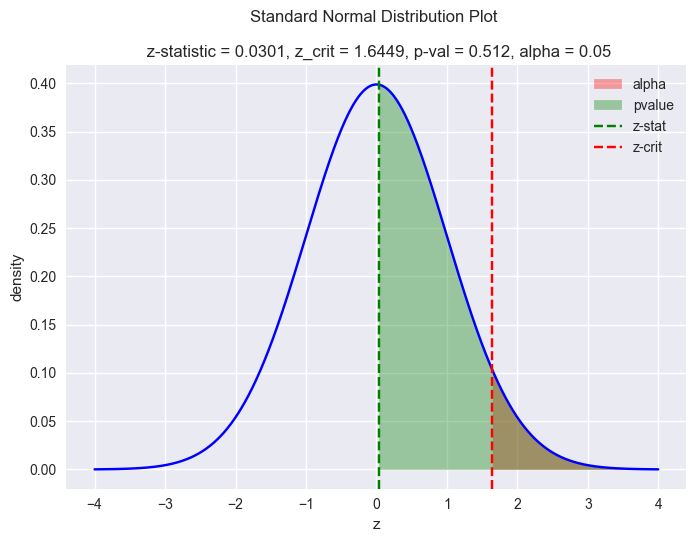

In [23]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot sample distribution 
x = np.arange(-4, 4, 0.001)
plt.plot(x, stats.norm.pdf(x, 0, 1), 
         color='blue')

# plot alpha region
x_alpha = np.arange(1.645, 4, 0.01)
y_alpha = stats.norm.pdf(x_alpha)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(z_stat, 4, 0.01)
y_pvalue = stats.norm.pdf(x_pvalue)
plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot z-crit and z-stats
plt.axvline(np.round(z_stat, 4), 
            color ="green", 
            linestyle = "--", 
            label ="z-stat")
plt.axvline(z_crit, 
            color ="red", 
            linestyle = "--", 
            label ="z-crit")

plt.legend()
plt.xlabel("z")
plt.ylabel("density")

plt.title(f'Standard Normal Distribution Plot \n\n z-statistic = {np.round(z_stat, 4)}, z_crit = {np.round(z_crit, 4)}, p-val = {np.round(p_value, 4)}, alpha = 0.05');

- Based on statistic test and p-value, failed to reject the Null hypothesis. 
   $$H_0:P_1 \geq P_2$$
- This means that there is not enough evidence to conclude that the proportion of clicks from the landing page in November is less or equal to the proportion of clicks from the landing page in October.

#### Confidence interval

After that, we will compute confidence interval to estimate in what range, our proportion difference in population

*   To calculate confidence interval for proportion, we can use [statsmodels.stats.proportion.confint_proportions_2indep](https://https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.confint_proportions_2indep.html)

1. import library
  - import statsmodels.api
  
  
2. Use function `statsmodels.stats.proportion.confint_proportions_2indep(count1, nobs1, count2, nobs2, compare='diff', alpha=0.05)')`

  - `count1, nobs1` = number of successes and number of observation for first sample.
  
  - `count2, nobs2` = number of successes and number of observation for second sample.
  
  - `alpha` = significance level 
  
  - `compare` = what type of comparison used
      - `diff` if you find confidence interval of $p_1-p_2$ 
      - `ratio` if you find confidence interval of $\frac{p_1}{p_2}$
      - `odds-ratio` confidence interval = $\frac{\frac{p_1}{1-p_1}}{\frac{p_2}{1-p_2}}$

3. The function will return lower and upper limits of the confidence interval


In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import confint_proportions_2indep

confidence_interval = confint_proportions_2indep(count1 = november_clicks_len, nobs1 = november_clicks_sum,
                                                 count2 = october_clicks_len, nobs2 = october_clicks_sum, 
                                                 compare='diff', alpha=0.05)
print(confidence_interval)

(-0.0001457027007943202, 0.00014952994627041288)


we are 95% confident that the true difference in means falls within the interval (-0.0001457027007943202, 0.00014952994627041288).

### Conclusion 
- As the p value > alpha(0.05) , we fail to reject $H_0$. 
- Therefore, from the data we can say that we can't reject if the The proportion of clicks from landing page in November is **greater than** to the proportion of clicks from landing page in October.

Recommendation for business:
- Continue using the landing page October

## **Linear Regression**
---

In [25]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

- Let's continue exploring marketing data
- Here, we have five months' worth of data on ad performance that records information about marketing in general.
- We want to know more than just the relationship between `Cost` and `Revenue`, we have other variable that hypothetically related to charges.
- First, assume we want to know how the `Sale Amount` variable relate to `Cost`

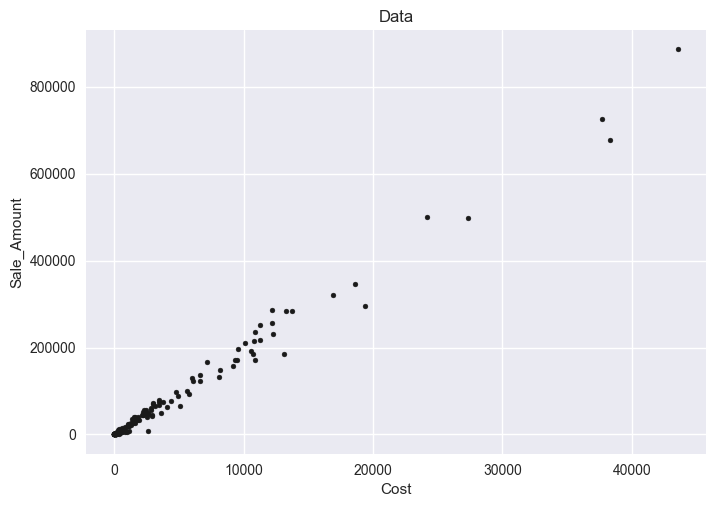

In [26]:
x = marketing['Cost']
y = marketing['Sale_Amount']

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels

plt.xlabel("Cost")
plt.ylabel("Sale_Amount")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

- From the visualization itself, the cost of the product increases, the sale_amount also tends to increase.

In [27]:
# Create OLS model object
model = smf.ols('Sale_Amount ~ Cost', marketing)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_sale_amount_cost = print_coef_std_err(results)

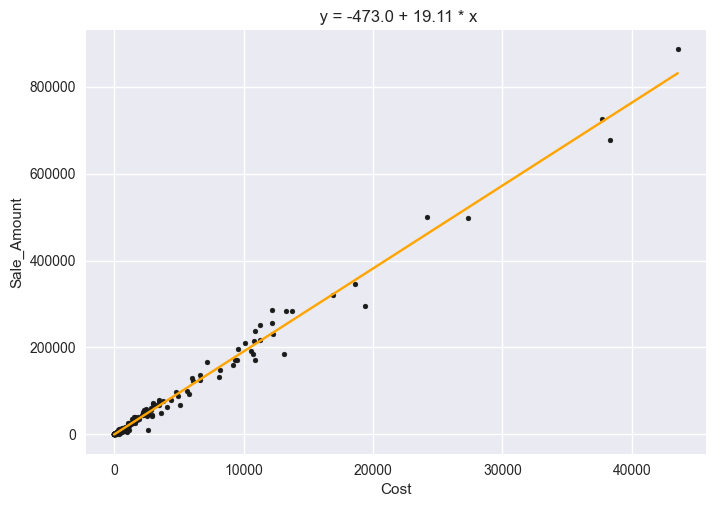

In [28]:
predictor = "Cost"
outcome = "Sale_Amount"
data = marketing.copy()
results_ = results_sale_amount_cost.copy()

# scatter-plot data
x = marketing['Cost']
y = marketing['Sale_Amount']

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "orange")

plt.ylabel("Sale_Amount")
plt.xlabel("Cost")
plt.title(f" y = {np.round(a_hat)} + {np.round(b_hat, 2)} * x")

plt.show()

$$\text{Sale_Amount} = -473.0 + 19.11\text{Cost} $$

- The simple regression line with one predictor So, the interpretation of this equation is that there is a positive relationship between "Cost" and "Sale_Amount", with the "Sale_Amount" increasing as the "Cost" increases. However, the negative intercept term suggests that there may be other factors impacting the "Sale_Amount" that are not captured by the "Cost" variable
- Let's explore if other variable can help us tells what's going on in our data

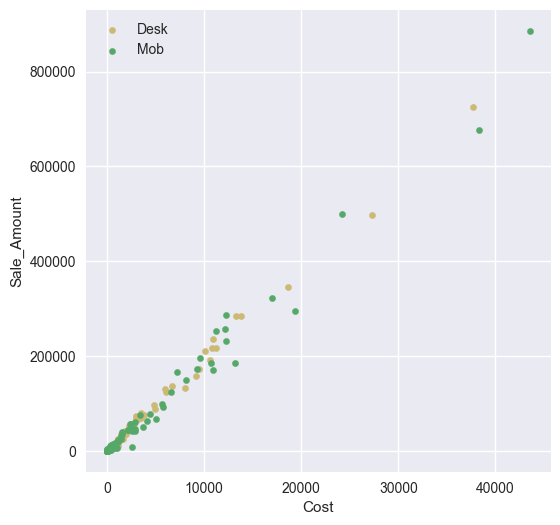

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define different color for each group data
colors = {"Desk":"y","Mob":"g"}

grouped = marketing.groupby('device_type')

# Plot the data with different color
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Cost', y='Sale_Amount', label=key, color=colors[key])
plt.show()

- From the visualization, we see that variable `device_type` can differentiate the data in cost values
- Next, try to add the `Mob` variable in the regression model to get more interpretable result 

- Do simple preprocessing to convert the device type that contain string "Desk" and "Mob" to binary (1 for "Mob", 0 for "Desk") to do numerical calculation in more convenient way in ols and displaying fitted regression line

In [30]:
# Use LabelEncoder to convert the smoker variable into numeric
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder Object and transform the smoker variable
marketing["device_type"] = LabelEncoder().fit_transform(marketing["device_type"])

# Display the 5th first row after transforming
marketing[["device_type","Sale_Amount"]].head()

,device_type,Sale_Amount
0,0,136770.05
1,0,283215.21
2,0,39165.46
3,0,284823.48
4,0,7717.77


In [31]:
# Create OLS model object
model = smf.ols('Sale_Amount ~ Cost + device_type', marketing)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_sale_amount_cost = print_coef_std_err(results)

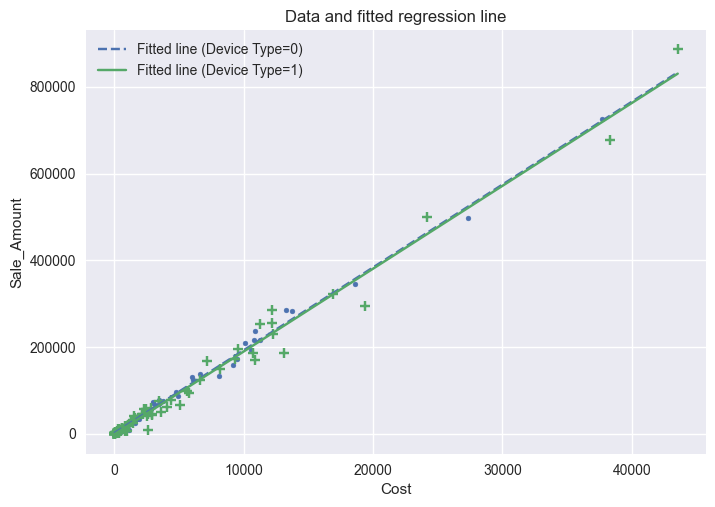

In [32]:
predictors = ["Cost","device_type"]
outcome = "Sale_Amount"
data = marketing.copy()
results_ = results_sale_amount_cost.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "+"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], 
                marker = markers[i])
    
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)


# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i for i in range(2)]


# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (Device Type={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

- The regression line after including `device_type` variable seems tell the relationship belong to each subpopulation based on value in the `device_type` predictor
- However, it still have the same slopes, contrasting the pattern in the data that suggests that the slopes differ substantially

### Fit Linear Regression - Include an Interaction 

In [33]:
# Create OLS model object
model = smf.ols('Sale_Amount ~ Cost + device_type + device_type:Cost', marketing)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_device_type_Cost_inter_sale_amount = print_coef_std_err(results)

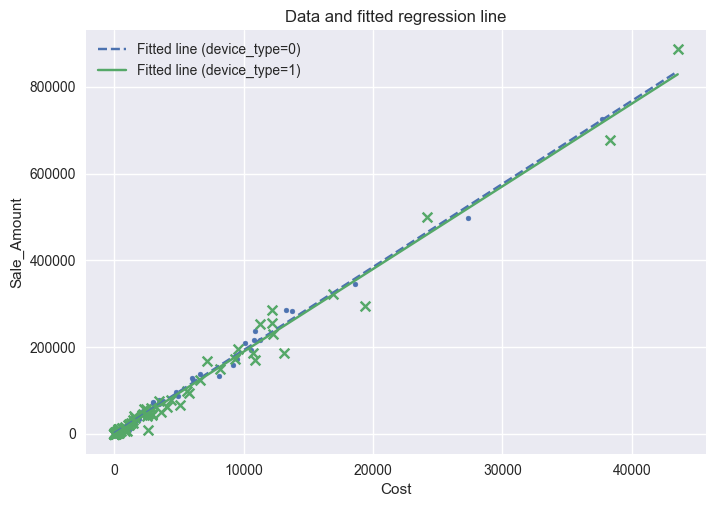

In [34]:
predictors = ["Cost","device_type","device_type:Cost"]
outcome = "Sale_Amount"
data = marketing.copy()
results_ = results_device_type_Cost_inter_sale_amount.copy()
linestyles = {0 : "--", 1: "-"}
c = {0 : "b", 1: "g"}
markers = {0 : ".", 1: "x"}

# Plot the data
for i in range(2):
    plt.scatter(data[data[predictors[1]]==i][predictors[0]], data[data[predictors[1]]==i][outcome], 
                color = c[i], marker = markers[i])

# Calculate the fitted values for two lines regarding the mom_hs
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]

fitted_values = [beta0_hat +  beta1_hat * x_domain  + beta2_hat * i + beta3_hat * i * x_domain for i in range(2)]

x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), 100)

# Plot two fitted line
for i in range(2):
    plt.plot(x_domain, fitted_values[i], c = c[i], label = f"Fitted line (device_type={i})", linestyle = linestyles[i])

# Add a legend and labels
plt.legend()
plt.ylabel(f"{outcome}")
plt.xlabel(f"{predictors[0]}")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

- Finally we have the regression line that can tell the two groups of data have different slopes

### Coefficient Interpretation 

In [35]:
results_device_type_Cost_inter_sale_amount

,coef,std err
Intercept,800.261921,1611.238033
Cost,19.175124,0.246947
device_type,-2627.825327,2257.111912
device_type:Cost,-0.097671,0.316012


$$\text{Sale_Amount} = 800 + 19\text{Cost} -2627\text{device_type} - 0.09\text{device_type*Cost}$$

### **Scale better unit for Sale_Amount**

In [36]:
marketing['Sale_Amount'] = marketing['Sale_Amount']/1000

In [37]:
# Create OLS model object
model = smf.ols('Sale_Amount ~ Cost + device_type + device_type:Cost', marketing)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_device_type_Cost_inter_sale_amount = print_coef_std_err(results)
results_device_type_Cost_inter_sale_amount

,coef,std err
Intercept,0.800262,1.611238
Cost,0.019175,0.000247
device_type,-2.627825,2.257112
device_type:Cost,-0.000098,0.000316


In [38]:
col = ['Impressions','Clicks','CTR','Conversions','Conversion_Rate','Cost','CPC','Revenue','Sale_Amount','P&L']

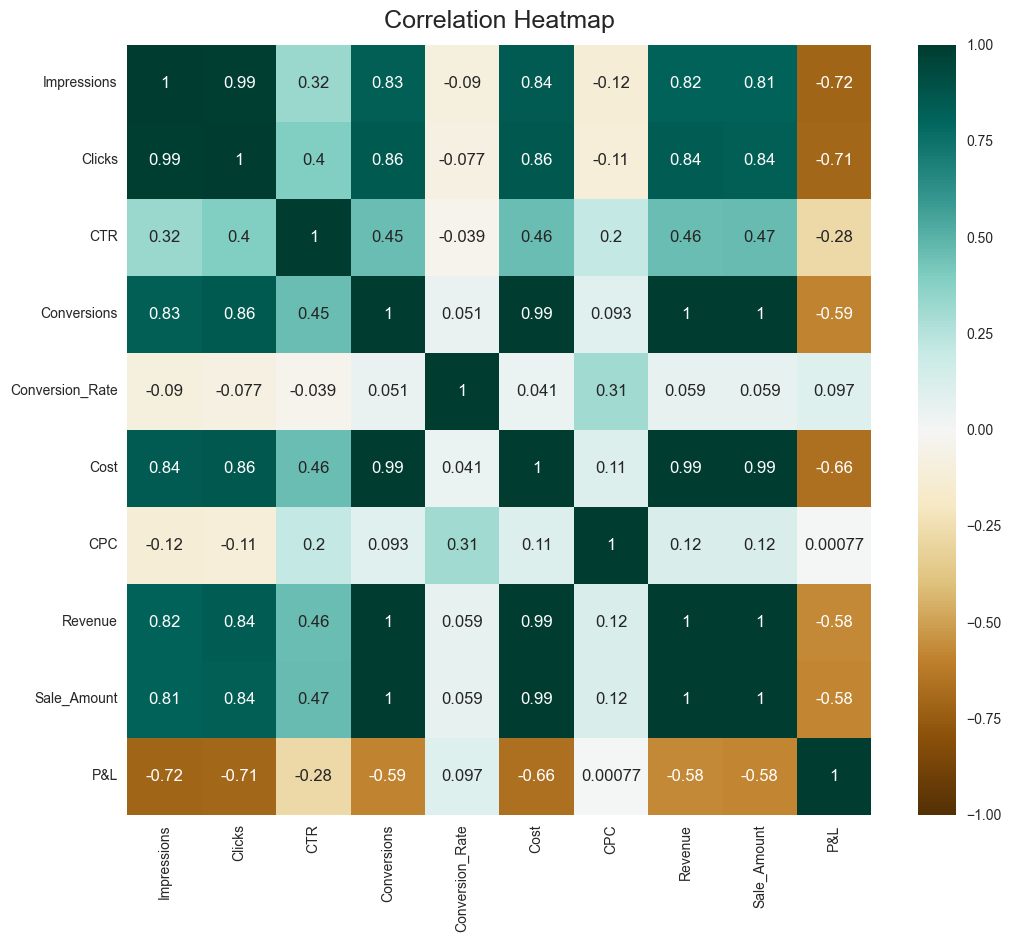

In [39]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(marketing[col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

- The Sale_Amount variable have 0.99 correlation with the Cost

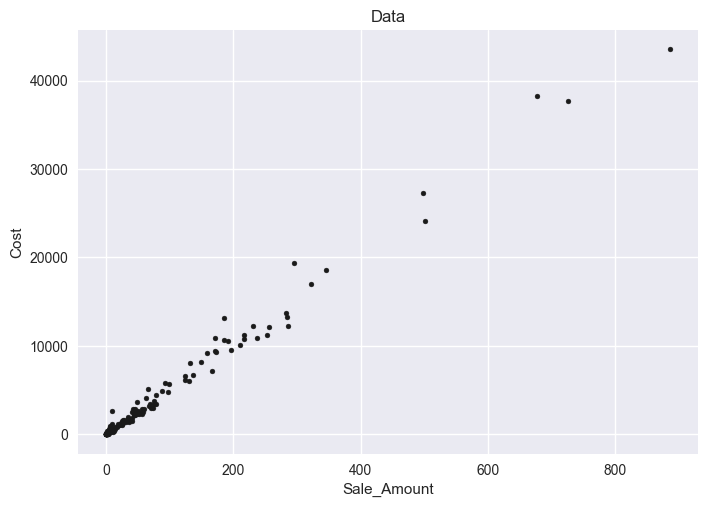

In [40]:
import matplotlib.pyplot as plt

x = marketing["Sale_Amount"]
y = marketing["Cost"]

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels

plt.xlabel("Sale_Amount")
plt.ylabel("Cost")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

In [41]:
# Create OLS model object
model = smf.ols("Sale_Amount ~ Cost", marketing)

# Fit the model
results1 = model.fit()
y_pred = results1.predict(marketing['Cost'])
# Extract the results (Coefficient and Standard Error) to DataFrame
results_sale_amount = print_coef_std_err(results1)

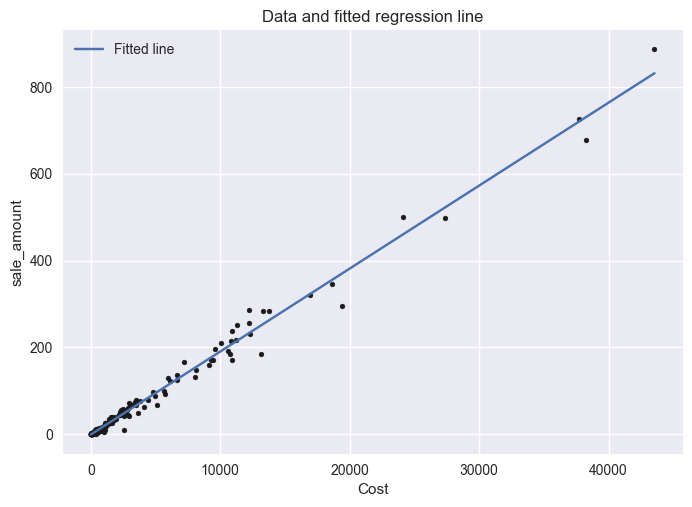

In [42]:
predictor = "Cost"
outcome = "Sale_Amount"
data = marketing.copy()
results_ = results_sale_amount.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), len(data))

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend()
plt.ylabel("sale_amount")
plt.xlabel("Cost")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

- Plot the residual from the fitted line

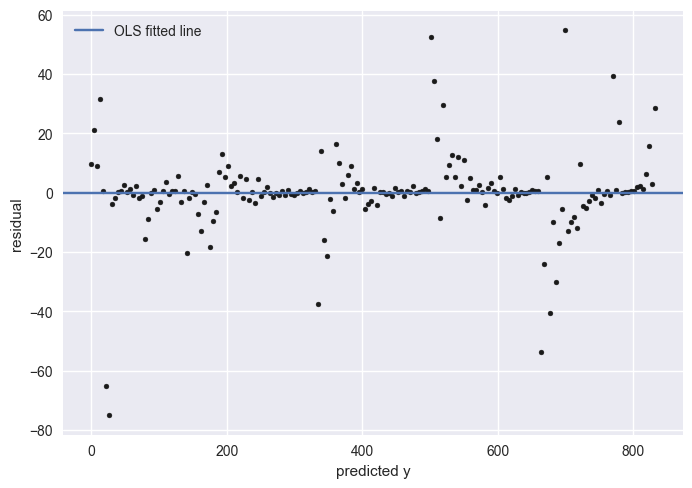

In [43]:
# plot the predicted values, and the residual
plt.scatter(fitted_values, results1.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="OLS fitted line")
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()

- The residual we get, have unconstant pattern around the zero

- Lets try use weighted regression to address this issue, and see what happening
- Give the lower weight in the data that have high variance, so set the weight inverse proportional of the predictor as we see that, the variance increase as the lot increase 

#### Residual Plot and Explained Variance

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

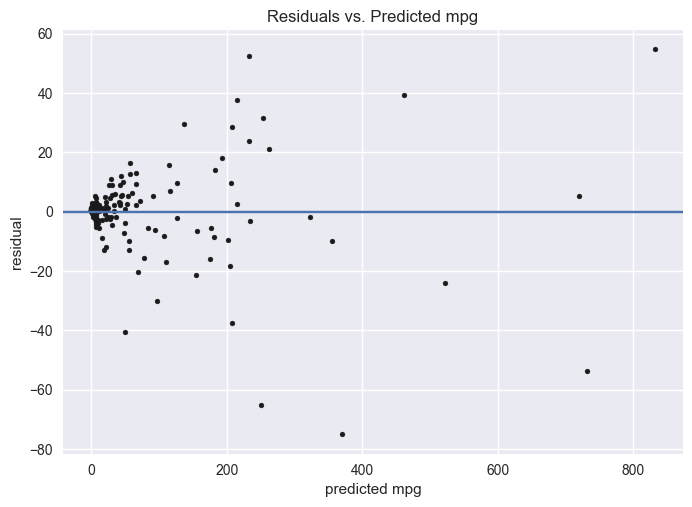

In [44]:
plt.scatter(results1.fittedvalues, results1.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [45]:
results1.rsquared

0.987926379482842

In [46]:
rsme = mean_squared_error(marketing['Sale_Amount'], y_pred, squared=False)
rsme

13.74425350360427

#### Normality of error assumption 

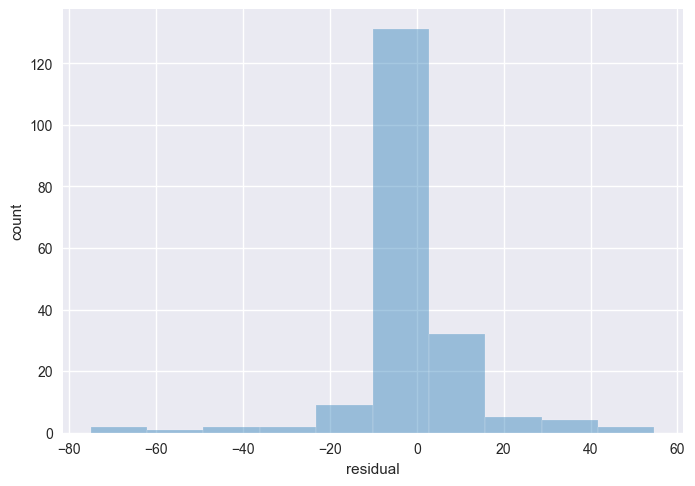

In [47]:
plt.hist(results1.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [48]:
weights = 1/(marketing["Cost"]**2)
marketing["weights"] = weights

In [49]:
marketing.sort_values(by='Sale_Amount')

,Ad_Group,Month,Impressions,Clicks,CTR,Conversions,Conversion_Rate,Cost,CPC,Revenue,Sale_Amount,P&L,name_store,keyword_match,device_type,landing_page,weights
72,Shop - Phrase - Mob - Free Shipping,August,111,27,0.24,0,0.00,8,0.30,0,0.00000,-8.000,Shop,Phrase,1,Free Shipping,1.562500e-02
27,Shop - Phrase - Desk - Free Shipping,July,66,8,0.12,0,0.00,3,0.48,0,0.00000,-3.000,Shop,Phrase,0,Free Shipping,1.111111e-01
110,Shop - Phrase - Mob - Free Shipping,September,98,22,0.22,0,0.00,6,0.29,0,0.00000,-6.000,Shop,Phrase,1,Free Shipping,2.777778e-02
34,Shop - Phrase - Mob - Free Shipping,July,118,15,0.13,0,0.00,6,0.40,0,0.00000,-6.000,Shop,Phrase,1,Free Shipping,2.777778e-02
181,Shop - Phrase - Desk - Free Shipping,November,85,9,0.11,0,0.00,2,0.32,0,0.00000,-2.000,Shop,Phrase,0,Free Shipping,2.500000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Shop - 1:1 - Desk - [shop coupon],November,73448,25283,0.34,4080,0.10,27336,1.08,23857,497.79081,-3478.644,Shop,1:1,0,[shop coupon],1.338228e-09
175,Shop - 1:1 - Mob - [shop coupon code],November,99258,42283,0.43,4349,0.08,24149,0.57,24071,500.40085,-77.730,Shop,1:1,1,[shop coupon code],1.714753e-09
151,Shop - 1:1 - Mob - [shop coupon],November,276568,99526,0.36,5961,0.05,38273,0.38,32668,677.18810,-5605.297,Shop,1:1,1,[shop coupon],6.826766e-10
153,Shop - 1:1 - Desk - [shop promo code],November,64067,23538,0.37,5782,0.15,37729,1.60,34518,725.77392,-3211.121,Shop,1:1,0,[shop promo code],7.025050e-10


In [50]:
# Create WLS (Weighted Least Square) model object and include the weight
model = smf.wls("Sale_Amount ~ Cost", marketing, weights = weights)

# Fit the model
results2 = model.fit()
y_pred = results2.predict(marketing['Cost'])
# Ey_pred = results1.predict(marketing['Cost'])xtract the results (Coefficient and Standard Error) to DataFrame
results_sale_amount_weighted = print_coef_std_err(results2)

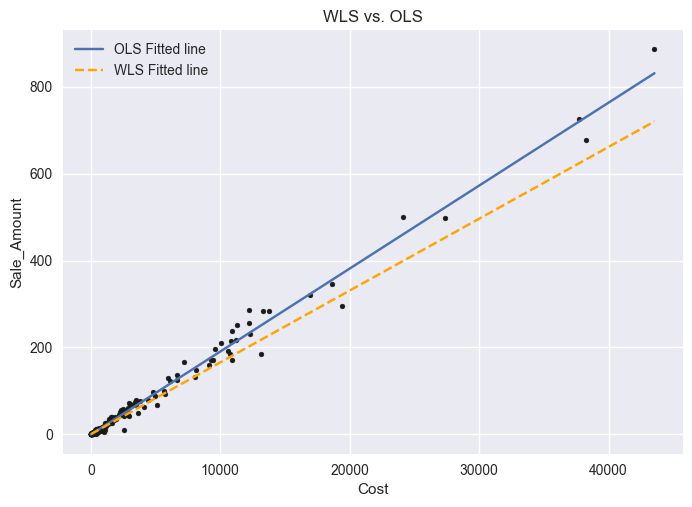

In [51]:
predictor = "Cost"
outcome = "Sale_Amount"
data = marketing.copy()
results_1 = results_sale_amount.copy()
results_2 = results_sale_amount_weighted.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat1 = results_1.loc["Intercept"]["coef"]
b_hat1 = results_1.loc[predictor]["coef"]

# Calculate the fitted values
a_hat2 = results_2.loc["Intercept"]["coef"]
b_hat2 = results_2.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), len(data))

fitted_values1 = a_hat1 + b_hat1 * x_domain
fitted_values2 = a_hat2 + b_hat2 * x_domain


# Plot the fitted line
plt.plot(x_domain, fitted_values1, label="OLS Fitted line", color = "b")

# Plot the fitted line
plt.plot(x_domain, fitted_values2, label="WLS Fitted line", color = "orange", linestyle = "--")

# Add a legend and labels
plt.legend()
plt.ylabel("Sale_Amount")
plt.xlabel("Cost")

# Add a title and adjust the margins
plt.title("WLS vs. OLS")

# Show the plot
plt.show()

The weighted residual plot

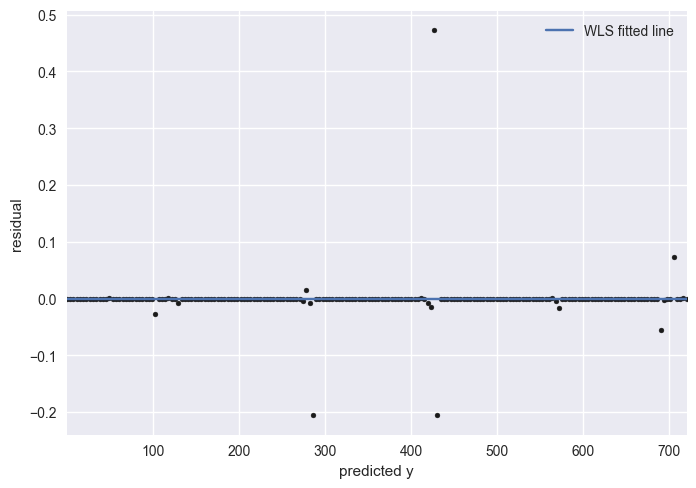

In [52]:
# plot the predicted values, and the residual
plt.scatter(fitted_values2, results2.resid * weights, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="WLS fitted line")

plt.xlim(min(fitted_values2), max(fitted_values2))
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()
plt.show()

- The pattern in weighted residual plot we get, surprisingly still not change much from the original one, however the slope we get from WLS could give a higher predicted values on the higher lot compared to the OLS


- We still can improve the model using by adjusting other weight to address the heteroscedasticity since there's no exact weight formula that we have to use

#### Residual Plot and Explained Variance

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

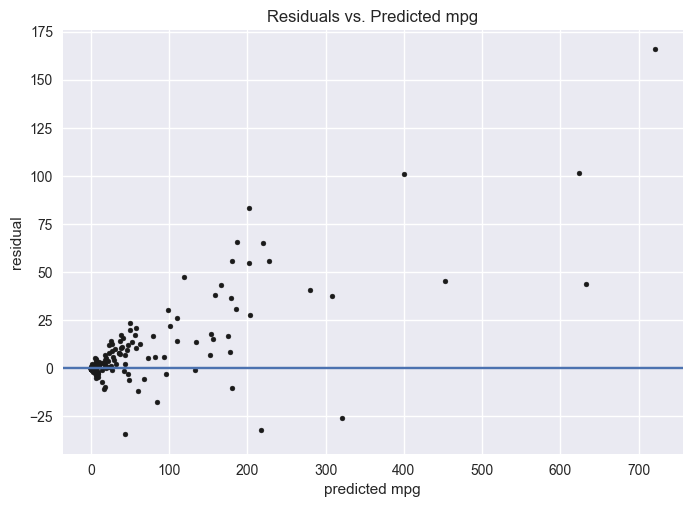

In [53]:
plt.scatter(results2.fittedvalues, results2.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [54]:
results2.rsquared

0.10642377642661549

In [55]:
rsme = mean_squared_error(marketing['Sale_Amount'], y_pred, squared=False)
rsme

23.028693178614326

#### Normality of error assumption 

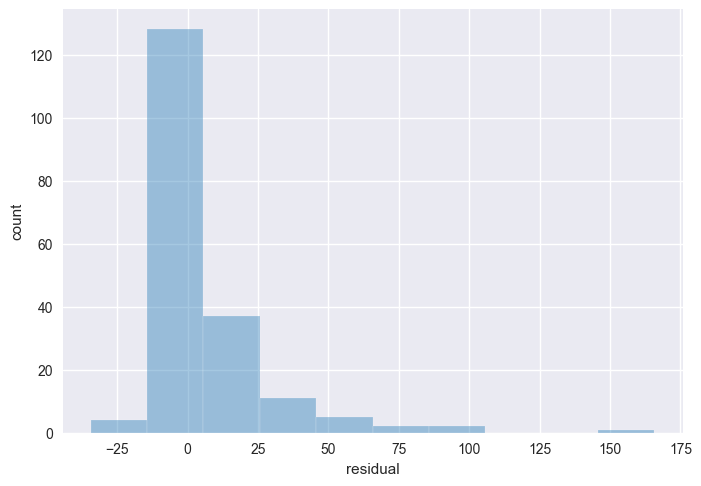

In [56]:
plt.hist(results2.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

- We see that the distribution of residual is nearly normal, however the assumption of normally error is minor for the purpose of estimating regression line.

- We can improve the model by doing transformation as remedies for linearity assumption violation (the data we have shows curved pattern)
- By employing transformations, we can utilize regression analysis to derive an equation that characterizes a nonlinear pattern. This method enables us to analyze data that exhibits a curved relationship.
- In business settings, two nonlinear transformations are especially valuable: reciprocals and logarithms. Reciprocals convert the observed data, d, into 1/d. On the other hand, logarithms convert d into log d.

### Numerical Varibales with each Categorical Variable

#### 1. Numerical Variables with Device Type

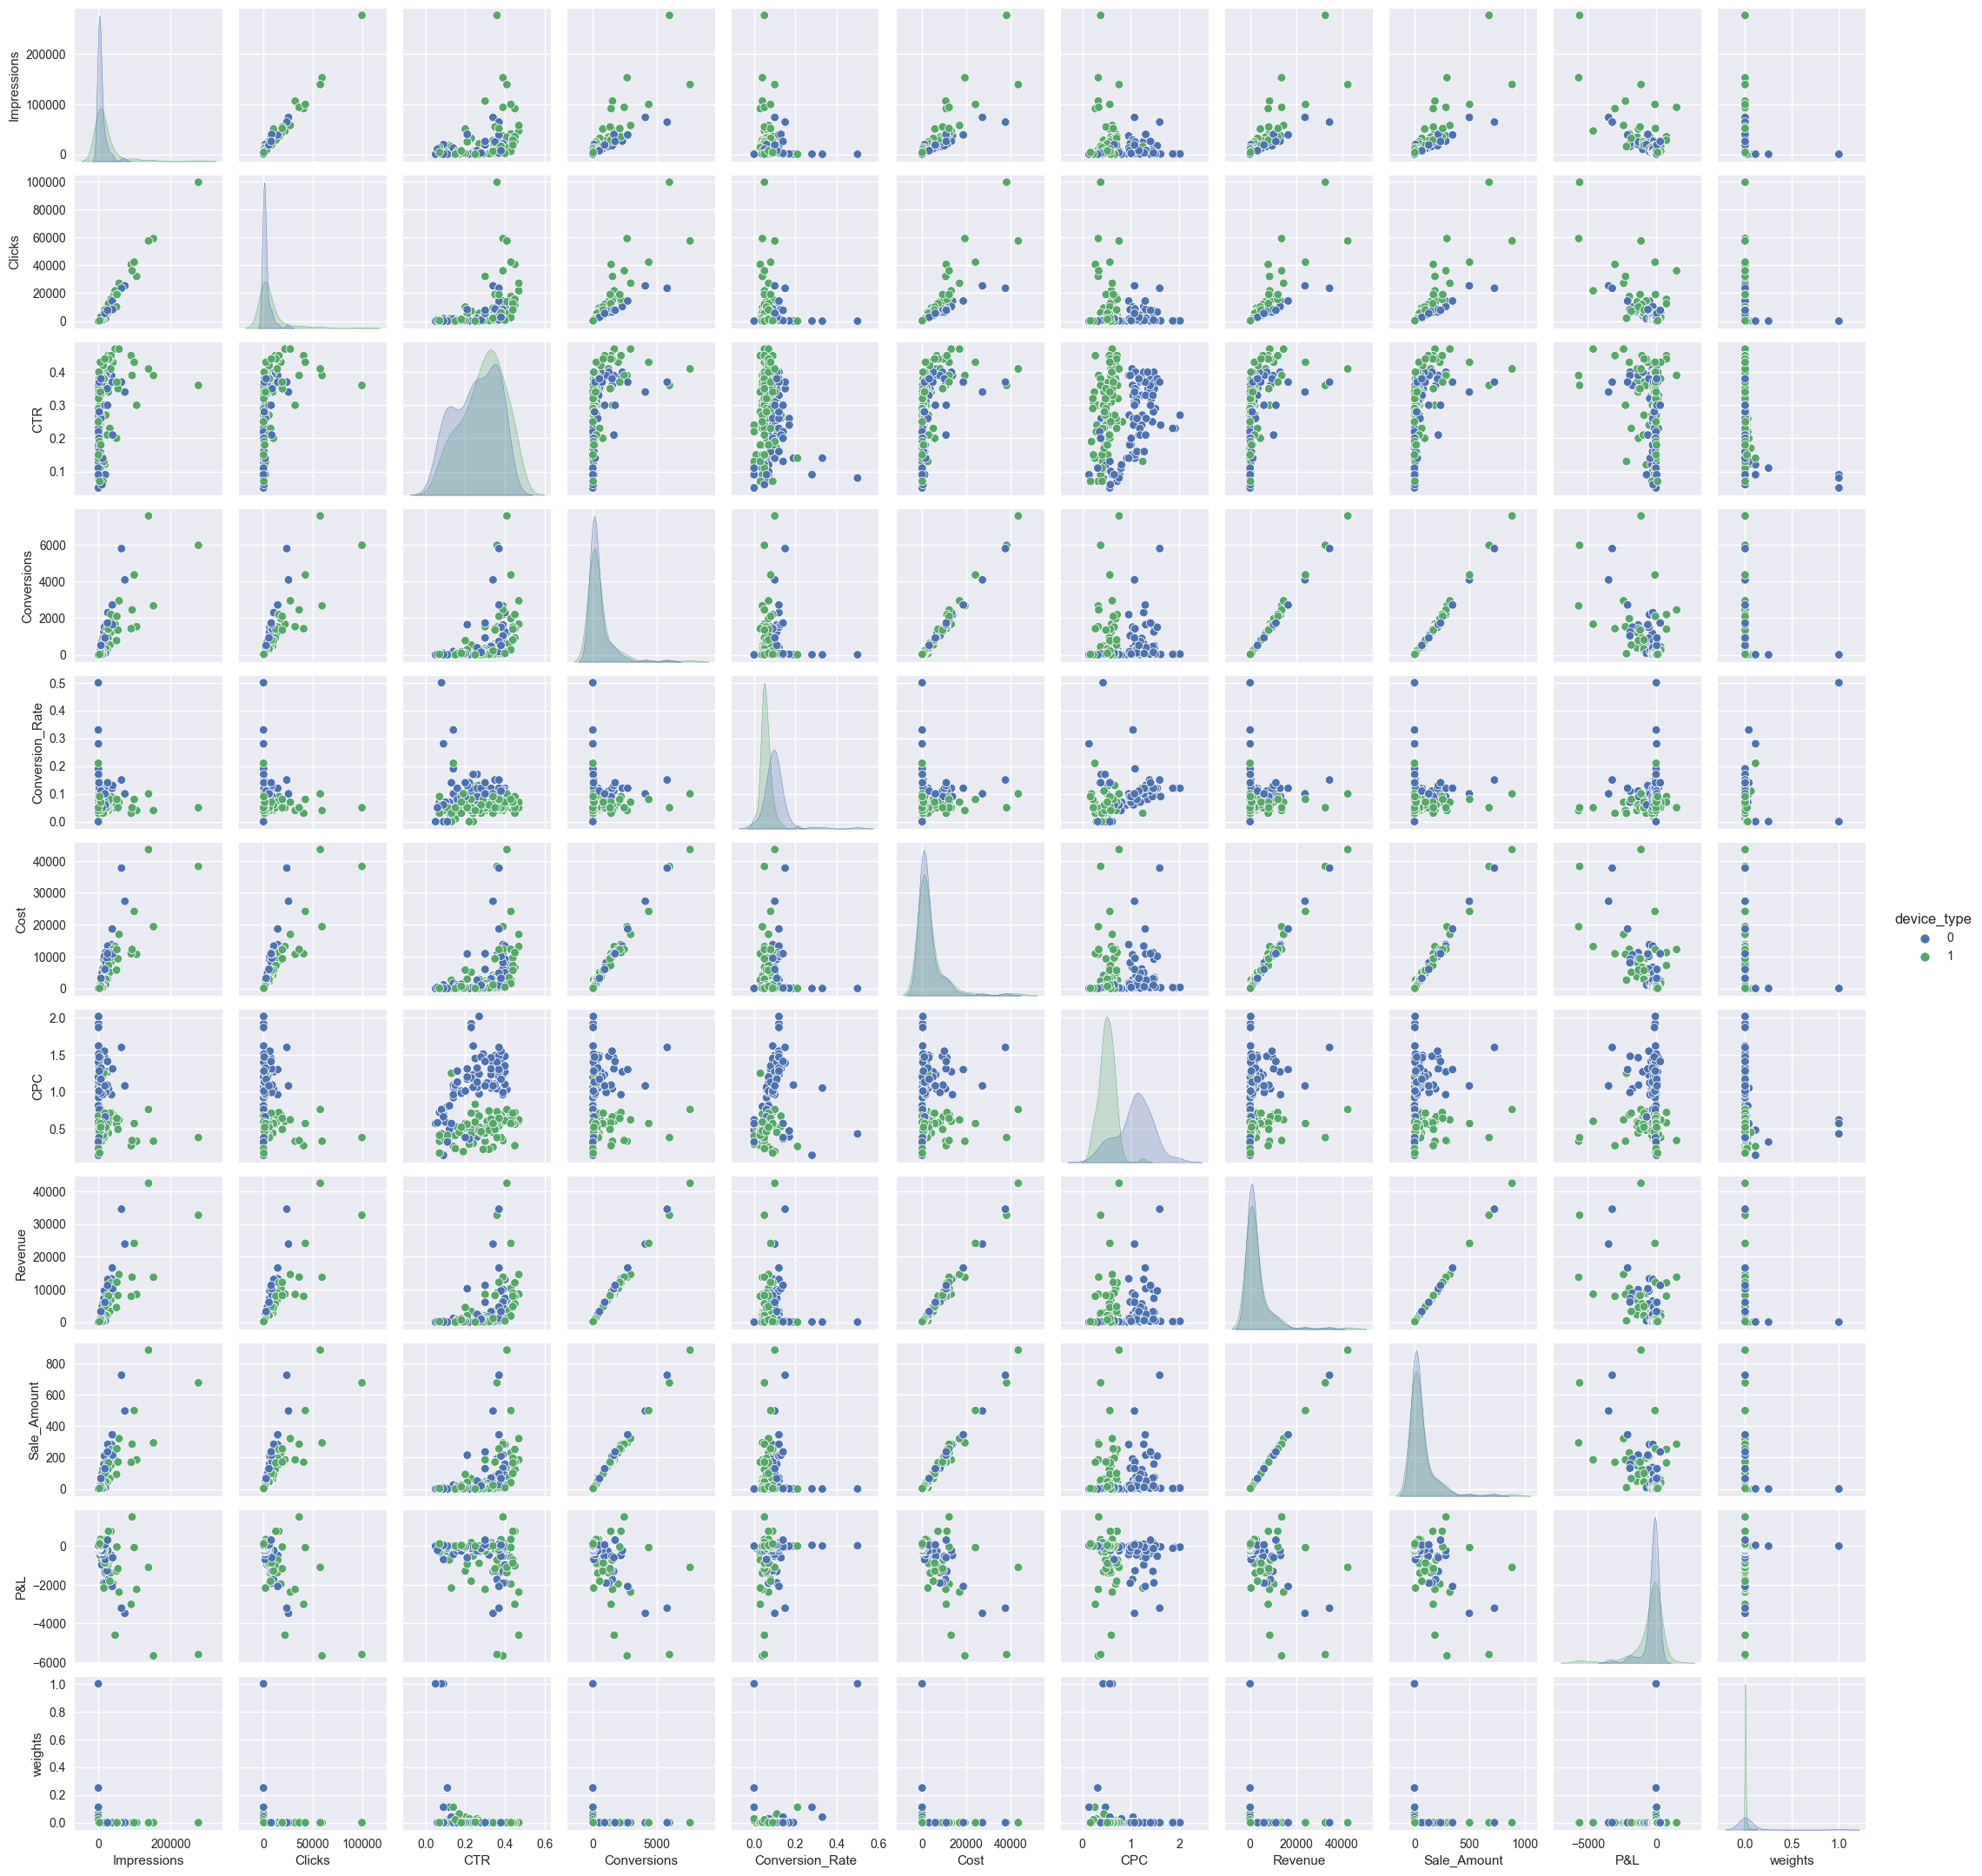

In [57]:
sns.pairplot(data = marketing, hue = "device_type", height=2)

- So lets's try to build the model of 
  - device_type + Clicks
  - device_type + Impressions

### Modelling


Define the model to fit for the data

In [58]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ad_Group         190 non-null    object 
 1   Month            190 non-null    object 
 2   Impressions      190 non-null    int64  
 3   Clicks           190 non-null    int64  
 4   CTR              190 non-null    float64
 5   Conversions      190 non-null    int64  
 6   Conversion_Rate  190 non-null    float64
 7   Cost             190 non-null    int64  
 8   CPC              190 non-null    float64
 9   Revenue          190 non-null    int64  
 10  Sale_Amount      190 non-null    float64
 11  P&L              190 non-null    float64
 12  name_store       190 non-null    object 
 13  keyword_match    190 non-null    object 
 14  device_type      190 non-null    int32  
 15  landing_page     190 non-null    object 
 16  weights          190 non-null    float64
dtypes: float64(6), i

In [59]:
# Create a class model

ols_device_cliks = StatsmodelsRegressor(smf.ols, "Sale_Amount ~  Clicks + device_type")
ols_device_impressions = StatsmodelsRegressor(smf.ols, "Sale_Amount ~  Impressions + device_type")

### Performing Cross Validation

To calculate the explained variance as the performance of the model, use cross validation to have more generalized performance

#### Data Splitting Results

In [60]:
fold_train, fold_test = kfold_split(data = marketing, n_fold = 5)

fold 1, train data rows: 152, test data rows: 38
fold 2, train data rows: 152, test data rows: 38
fold 3, train data rows: 152, test data rows: 38
fold 4, train data rows: 152, test data rows: 38
fold 5, train data rows: 152, test data rows: 38


In [61]:
fold_train[0]

,Ad_Group,Month,Impressions,Clicks,CTR,Conversions,Conversion_Rate,Cost,CPC,Revenue,Sale_Amount,P&L,name_store,keyword_match,device_type,landing_page,weights
0,Shop - 1:1 - Desk - [shop coupon code],July,16038,6504,0.41,1166,0.10,6669,1.03,6402,136.77005,-267.086,Shop,1:1,0,[shop coupon code],2.248426e-08
1,Shop - 1:1 - Desk - [shop coupon],July,36462,14367,0.39,2188,0.09,13746,0.96,13262,283.21521,-483.951,Shop,1:1,0,[shop coupon],5.292335e-09
2,Shop - 1:1 - Desk - [shop discount code],July,3635,1458,0.40,248,0.09,1606,1.10,1723,39.16546,117.136,Shop,1:1,0,[shop discount code],3.877117e-07
3,Shop - 1:1 - Desk - [shop promo code],July,26185,10418,0.40,2294,0.12,13278,1.27,13042,284.82348,-235.921,Shop,1:1,0,[shop promo code],5.671980e-09
5,Shop - 1:1 - Mob - [shop coupon code],July,46507,21756,0.47,1665,0.05,13157,0.60,8550,185.82449,-4606.713,Shop,1:1,1,[shop coupon code],5.776786e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Shop - Exact - Desk - Black Friday/Cyber Monday,November,257,24,0.09,7,0.28,3,0.14,45,0.89880,41.946,Shop,Exact,0,Black Friday/Cyber Monday,1.111111e-01
186,Shop - 1:1 - Desk - [shop discount code],November,7254,2725,0.38,512,0.11,3182,1.17,3227,66.67229,45.468,Shop,1:1,0,[shop discount code],9.876422e-08
187,Shop - Exact - Desk - Coupon Code,November,18526,5553,0.30,919,0.10,5982,1.08,6047,129.55690,64.552,Shop,Exact,0,Coupon Code,2.794520e-08
188,Shop - Exact - Mob - Black Friday/Cyber Monday,November,3662,266,0.07,24,0.09,44,0.17,160,3.26863,115.963,Shop,Exact,1,Black Friday/Cyber Monday,5.165289e-04


In [62]:
fold_test[0]

,Ad_Group,Month,Impressions,Clicks,CTR,Conversions,Conversion_Rate,Cost,CPC,Revenue,Sale_Amount,P&L,name_store,keyword_match,device_type,landing_page,weights
4,Shop - 1:1 - Desk - [shop promo],July,808,282,0.35,61,0.15,391,1.39,337,7.71777,-53.604,Shop,1:1,0,[shop promo],6.541035e-06
19,Shop - Exact - Mob - Discount Code,July,6278,1506,0.24,59,0.03,817,0.54,313,6.42067,-504.332,Shop,Exact,1,Discount Code,1.498152e-06
23,Shop - Exact - Mob - Sale,July,9812,1008,0.10,42,0.04,413,0.41,202,4.24270,-210.844,Shop,Exact,1,Sale,5.862730e-06
26,Shop - Phrase - Desk - Discount Code,July,1062,147,0.14,13,0.06,135,0.92,67,1.68255,-68.055,Shop,Phrase,0,Discount Code,5.486968e-05
31,Shop - Phrase - Mob - Competitor,July,55,11,0.20,2,0.10,5,0.51,16,0.31350,10.675,Shop,Phrase,1,Competitor,4.000000e-02
33,Shop - Phrase - Mob - Discount Code,July,1813,264,0.15,4,0.01,138,0.53,21,0.41962,-117.017,Shop,Phrase,1,Discount Code,5.250998e-05
37,Shop - Phrase - Mob - Sale,July,17807,2054,0.12,35,0.03,981,0.48,262,5.53115,-718.568,Shop,Phrase,1,Sale,1.039111e-06
41,Shop - 1:1 - Desk - [shop coupon],August,28499,10141,0.36,1509,0.08,10586,1.04,8859,192.10572,-1727.135,Shop,1:1,0,[shop coupon],8.923520e-09
42,Shop - 1:1 - Mob - [shop coupon code],August,34189,13905,0.41,1218,0.06,8146,0.59,6766,148.68116,-1380.324,Shop,1:1,1,[shop coupon code],1.506993e-08
50,Shop - 1:1 - Mob - [shop discount code],August,7544,2523,0.33,216,0.05,1590,0.63,1591,35.60511,1.360,Shop,1:1,1,[shop discount code],3.955540e-07


In [63]:
# Create k-fold splitter object

kfold = KFold(n_splits=5, shuffle = True, random_state=123)

1. Regression model using Cost and Device Type variables

#### Calculate performance for each model

In [64]:
fold_train, fold_test = kfold_split(data = marketing, n_fold = 5)

fold 1, train data rows: 152, test data rows: 38
fold 2, train data rows: 152, test data rows: 38
fold 3, train data rows: 152, test data rows: 38
fold 4, train data rows: 152, test data rows: 38
fold 5, train data rows: 152, test data rows: 38


In [65]:
scores_ols_device_cliks = cross_val_score(estimator = ols_device_cliks,
                                        X = marketing,
                                        y = marketing["Sale_Amount"],
                                        cv = kfold,
                                        scoring = "r2")
scores_ols_device_cliks = pd.DataFrame(data = scores_ols_device_cliks, columns=["test_rsquared"])
scores_ols_device_cliks["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_device_cliks["test_rsquared"].mean()

0.661628612682563

2. Regression model using Impressions and Device Type variables

In [66]:
scores_ols_device_impressions = cross_val_score(estimator = ols_device_impressions,
                                        X = marketing,
                                        y = marketing["Sale_Amount"],
                                        cv = kfold,
                                        scoring = "r2")
scores_ols_device_impressions = pd.DataFrame(data = scores_ols_device_impressions, columns=["test_rsquared"])
scores_ols_device_impressions["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_device_impressions["test_rsquared"].mean()

0.6300954391665438

The model with Clicks and Device type variables achieves the highest R-squared

Here's the performance in each folds

In [67]:
scores_ols_device_impressions

,test_rsquared,folds
0,0.738244,Folds 1
1,0.650096,Folds 2
2,0.660888,Folds 3
3,0.564846,Folds 4
4,0.536403,Folds 5


In [68]:
scores_ols_device_cliks

,test_rsquared,folds
0,0.767518,Folds 1
1,0.738723,Folds 2
2,0.726563,Folds 3
3,0.531770,Folds 4
4,0.543569,Folds 5


#### The cross validation score

In [69]:
print(f"Cliks : The average R-squared as cross validation score is {np.round(np.mean(scores_ols_device_cliks['test_rsquared']), 3)}")

Cliks : The average R-squared as cross validation score is 0.662


In [70]:
print(f"impressions : The average R-squared as cross validation score is {np.round(np.mean(scores_ols_device_impressions['test_rsquared']), 3)}")

impressions : The average R-squared as cross validation score is 0.63


### Fitting the model in whole data to get the estimated coefficients

In [71]:
# Centering Age to make intercept more interpretable
marketing["c_clicks"] = marketing["Clicks"] - marketing ["Clicks"].mean()

# Create OLS model object
model = smf.ols('Sale_Amount ~  c_clicks + device_type', marketing)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_ins = print_coef_std_err(results)
results_ins

,coef,std err
Intercept,81.966862,6.967482
c_clicks,0.009573,0.000438
device_type,-36.714889,9.907514


In [72]:
# Explain variance of the final model

results.rsquared

0.7192887580530039

In [73]:
results2

$$\text{Sale_Amount} = 81 + 0.009 \times \text{Device_Type} - 36 \times \text{centered_Clicks}$$

#### Notes

- keep in mind that the R-squared value is just one metric for evaluating the performance of a regression model, and it should be used in conjunction with other metrics such as RMSE, MAE, and cross-validated scores to get a more comprehensive view of the model’s predictive power.
- it’s important to ensure that the model assumptions are valid and that the model is not overfitting or underfitting the data :D